# ETL

- Visualise the data
- ETL of energy consumption raw data
- ETL of survey raw data

## Setup

In [2]:
# Standard imports
import logging

import dask
import dask.dataframe as dd
import hvplot.dask
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# Create a Dask dashboard to visualise and track memory, CPU and GPU usage.
from dask.distributed import Client, LocalCluster

# Only show errors, suppress warnings
dask.config.set({"logging.distributed": "error"})
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit="2GB",
    silence_logs=logging.ERROR,
)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40807,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:45811,Total threads: 2
Dashboard: http://127.0.0.1:41633/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:43309,


## Load Raw Data

In [4]:
# Load the survey data
survey_df = pd.read_csv(
    "../data/csv/household_survey/save_household_survey_data_v0-3.csv"
)

# Energy data
# Create a Dask dataframe that reads all of the 2017 energy data CSV files
df_2017 = dd.read_csv(
    "../data/csv/energy_consumption/2017/*.csv"
)

# Create a Dask dataframe that reads all of the 2018 energy data CSV files
df_2018 = dd.read_csv(
    "../data/csv/energy_consumption/2018/*.csv"
)

In [5]:
# Data cleaning
# Set datetime datatype
df_2017["received_timestamp"] = dd.to_datetime(
    df_2017["received_timestamp"], unit="s", origin="unix"
)
df_2017["recorded_timestamp"] = dd.to_datetime(
    df_2017["recorded_timestamp"], unit="s", origin="unix"
)
df_2018["received_timestamp"] = dd.to_datetime(
    df_2018["received_timestamp"], unit="s", origin="unix"
)
df_2018["recorded_timestamp"] = dd.to_datetime(
    df_2018["recorded_timestamp"], unit="s", origin="unix"
)

# Verify the datatype values
print(df_2017.info())
print(df_2018.info())

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 4 entries, bmg_id to energy
dtypes: datetime64[ns](2), float64(1), string(1)None
<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 4 entries, bmg_id to energy
dtypes: datetime64[ns](2), float64(1), string(1)None


#### Assumption 1

Number of households: 565


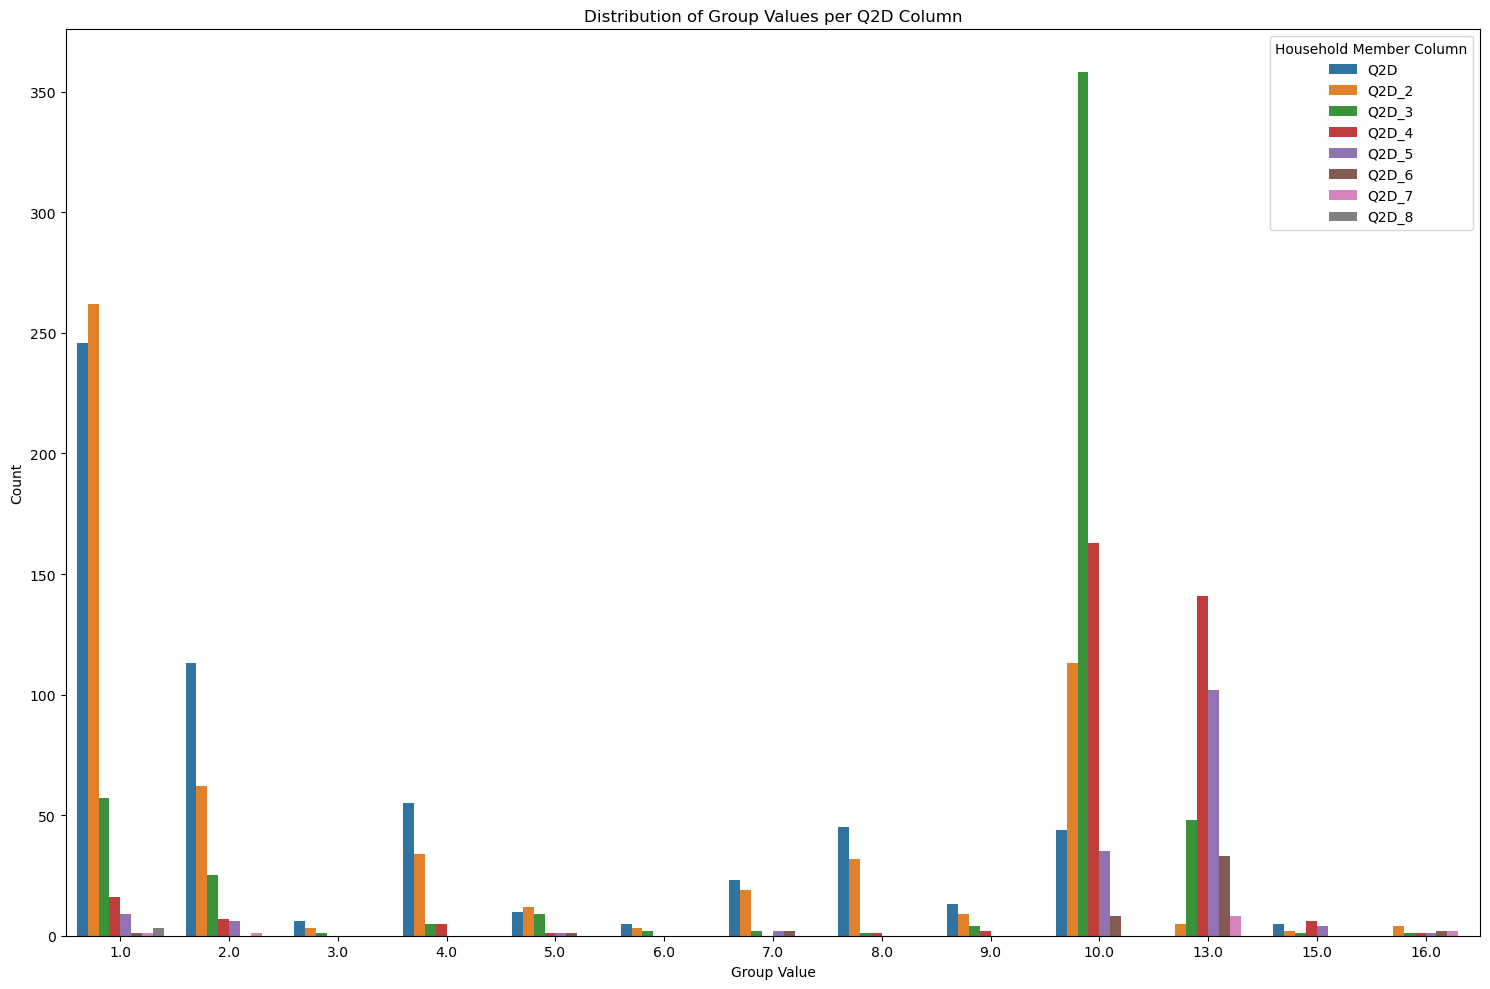

In [6]:
# Assumption 1: At least 1 student in the household
# List all Q2D columns representing household members
q2d_columns = [f"Q2D_{i}" if i > 1 else "Q2D" for i in range(1, 9)]

# Filter households where any existing Q2D values are in [10, 11, 12]
condition = survey_df[q2d_columns].apply(
    lambda row: row.dropna().isin([10, 11]).any(),
    axis=1,
)

# Extract BMG_IDs from those households
BMG_ID_student = survey_df.loc[condition, "BMG_ID"]
print(f"Number of households: {len(BMG_ID_student)}")

# Melt the DataFrame into long format
melted = survey_df[survey_df["BMG_ID"].isin(BMG_ID_student)][q2d_columns].melt(
    var_name="Q2D_Column", value_name="Group"
)

# Drop NaN values
melted = melted.dropna()

# Plot the count of each group value for each Q2D column
plt.figure(figsize=(15, 10))
sns.countplot(
    data=melted[melted["Group"] != 0],
    x="Group",
    hue="Q2D_Column",
    palette="tab10",
)
plt.title("Distribution of Group Values per Q2D Column")
plt.xlabel("Group Value")
plt.ylabel("Count")
plt.legend(title="Household Member Column")
plt.tight_layout()
plt.show()

## Extract

- Extract the student household data based on the above assumption
- Extract the important survey indicators based on the survey questionnaire

In [7]:
# Isolate student households

# Isolate the student households from the survey data.
student_survey_df = survey_df[survey_df["BMG_ID"].isin(BMG_ID_student)].copy()


def filter_student_energy(df):
    student_df = df[
        df["bmg_id"].astype(str).str[-9:].isin(BMG_ID_student.astype(str))
    ].copy()
    return student_df


# Filter 2017 and 2018 consumption data to reflect only student households
student_energy_2017_df = filter_student_energy(df_2017)
student_energy_2018_df = filter_student_energy(df_2018)

# Combine 2017 and 2018 student household energy consumption data
student_energy_df = dd.concat(
    [student_energy_2017_df, student_energy_2018_df], axis=0
)
print(student_energy_df.head())
print(student_energy_df.info())
# print(student_energy_df.isnull().sum().compute())

        bmg_id  received_timestamp  recorded_timestamp   energy
0  a2956649655 2016-12-26 00:00:04 2016-12-06 12:15:00  1158061
1  a2956649655 2016-12-26 00:00:04 2016-12-06 12:30:00  1158159
2  A4956660136 2016-12-26 00:00:05 2016-12-25 17:15:00   868136
4  A4956624221 2016-12-26 00:00:06 2016-12-26 00:00:00  1308987
5  A2956646108 2016-12-26 00:00:07 2016-12-25 23:30:00   888915
<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 4 entries, bmg_id to energy
dtypes: datetime64[ns](2), float64(1), string(1)None


In [8]:
print("All student survey information\n")
print(student_survey_df.head())
print(student_survey_df.info())

# Drop columns that are not required.
"""
	QUESTION	QUESTION LABEL	CODE/LABEL
72	Q3_1	Does your household own or rent this accommodation?	1 = Own outright
73			2 = Own with a mortgage or loan
74			3 = Part own and part rent (shared ownership)
75			4 = Rent (with or without housing benefit)
76			5 = Tied/linked to job
77			6 = Live here rent free
78			7 = Other
79			8 = Refused

	QUESTION	QUESTION LABEL	CODE/LABEL
81	Q3_2	Who is your landlord?	1 = Housing association, housing co-operative, charitable trust, registered social landlord
82			2 = Council (local authority)
83			3 = Private landlord or letting agency
84			4 = Employer of a household member
85			5 = Relative or friend of a household member
86			6 = Other
87			7 = Dont know

	QUESTION	QUESTION LABEL	CODE/LABEL	NOTES
91	Q3_3	How is electricity provided to your home?	1 = Mains	MULTIPLE RESPONSE: 1=True;0=False
92			2 = Solar panels that generate electricity/photovoltaic solar panels	
93			3 = Wind turbine	
94			4 = Hydro generator	
95			5 = Combined Heat and Power systems which generate heat and electricity simultaneously, with any excess electricity produced going back into the grid	
96			6 = Own generator	
97			7 = Other	
98			8 = Don't know	
99			9 = Not asked	

	QUESTION	QUESTION LABEL	CODE/LABEL
103	Q3_4	Do you have "green tariff" electricity?	1 = Yes
104			2 = No
105			3 = Don't know
106			
107	Q3_5	Do you have Economy 7, Economy 10 (also known as Heatwise) or Powershift?	1 = Yes - Economy 7
108			2 = Yes - Economy 10/Heatwise
109			3 = Yes - Powershift 7
110			4 = Yes - not sure which
111			5 = No
112			6 = Don't know
113			
114	Q3_6	Do you also have gas?	1 = Yes - mains
115			2 = Yes - LPG (Liquid Petroleum Gas)
116			3 = No
117			4 = Don't know
118			
114	Q3_9	Do you have a smart electricity and/or gas meter?	1 = Yes - smart electricity meter
135			2 = Yes - smart gas meter
136			3 = Both
137			4 = No
138			5 = Don't know
139			
143			
144	Q3_11	Do you tend to read your electricity meter, or do you rely on your electricity bills, or other sources, to tell you how much electricity your household is using?	1 = Read meter regularly
145			2 = Read meter when I get a bill
146			3 = Rely on electricity bills
147			4 = Read meter when I am asked to by provider
148			5 = None of these/don't take any notice
149			6 = Don't know
150			
151	Q3_12	What is your MAIN source of heating?	1 = Electricity - storage heaters
152			2 = Other electricity e.g. ground source heat pumps
153			3 = Gas boiler
154			4 = Oil e.g. fuel oil or heating oil
155			5 = Solid fuel e.g. wood or coal
156			6 = Biomass for boiler
157			7 = Open fire(s) and/or woodburning stove(s)
158			8 = Other
159			9 = Don't know

161	Q3_13	Which, if any, of the following does your main heating system have?	1 = Programmer/timer switch over which you have control
162			2 = Single house thermostat
163			3 = Room thermostats
164			4 = Thermostatic radiator valves
165			5 = Storage heater dials
166			6 = Don't know
167			7 = None

// This information is unreliable many rows have multiple times selected.
181	Q3_15	When was your house built?	1 = Pre 1850
182			2 = 1850 to 1899
183			3 = 1900  to 1918
184			4 = 1919 to 1930
185			5 = 1931 to 1944
186			6 = 1945 to 1964
187			7 = 1965 to 1980
188			8 = 1981 to 1990
189			9 = 1991 to 1995
190			10 = 1996 to 2001
191			11 = 2002 or later
192			12 = Don't know
193			13 = Refused
194			14 = Not asked

213	Q3_18	How is your water heated?	1 = Electric immersion heater (to hot water tank)
214			2 = Gas or oil direct heating (combi)
215			3 = Gas, oil or solid fuel (including wood) indirect heating (to hot water tank)
216			4 = Solar heating (to hot water tank)
217			5 = Other
218			6 = Don't know
219			7 = Refused

		QUESTION	QUESTION LABEL	CODE/LABEL	NOTES	...5	...6	...7	...8	...9	...10	...11	...12	...13	...14	...15	...16	...17	...18	...19	...20	...21	...22	...23	...24	...25	...26	...27	...28	...29	...30	...31	...32	...33	...34	...35	...36	...37
223	223	Q3_19_1	Can I check how many of the following you have in your home? Please only include those that are used at least once a week during the winter.	NUMERIC	SAME AS: Q3_19_2  TO Q3_19_33	_1	_2	_3	_4	_5	_6	_7	_8	_9	_10	_11	_12	_13	_14	_15	_16	_17	_18	_19	_20	_21	_22	_23	_24	_25	_26	_27	_28	_29	_30	_31	_32	_33
224	224					Coffee-maker	Combined washing machine and tumble dryer	Standalone tumble dryer	Standalone washing machine	Dishwasher	Electric hob	Electric oven	Gas hob	Gas oven	Fridge-freezer	Fridge	Standalone freezer	Toaster	Kettle	Microwave	TV with a screen less than 21 inches	TV with a screen more than 21 inches	DVD player/Personal Video Recorder (PVR) (eg. Sky/Virgin box)	Games console/X box/Playstation	Mobile phones that are plugged into the mains for use or charging	PC/laptop that is plugged into the mains for use or charging	Handheld devices (iPads etc) that are plugged into the mains for use or charging	Air conditioning unit	Cooling fans	Humidifier	Dehumidifier	Plug in electric heater (such as fan heater or bar heater)	Vacuum cleaner	Bath	Power shower	Shower (excluding power shower)	Electric blanket	Hair drier

	QUESTION	QUESTION LABEL	CODE/LABEL
264	Q6_1	Does your household have an electric vehicle? This does not include hybrids.	1 = Yes
265			2 = No
266			3 = Don't know

	QUESTION	QUESTION LABEL	CODE/LABEL
321	Q8_2	What type of property do you live in?	1 = Detached
322			2 = Semi detached
323			3 = Terraced or end terraced
324			4 = In a purpose-built block of flats or tenement
325			5 = Part of a converted or shared house (including bedsits)
326			6 = In a commercial building (for example in an office building, hotel, or over a shop)
327			7 = A caravan or other mobile or temporary structure
328			8 = Refused

	QUESTION	QUESTION LABEL	CODE/LABEL
349	Q8_6	How many rooms are available for use by your household (do not count hallways, landings, cupboards)? You should count all your bedrooms, living and reception rooms, kitchens, bathrooms, studies and conservatories, and any other rooms in your home)?	NUMERIC
"""
student_survey_important_df = student_survey_df[
    [
        "BMG_ID",
        "Q2C",
        "Q3_1",
        "Q3_2",
        "Q3_3_1",
        "Q3_3_2",
        "Q3_3_3",
        "Q3_3_4",
        "Q3_3_5",
        "Q3_3_6",
        "Q3_3_7",
        "Q3_3_8",
        "Q3_3_9",
        "Q3_4",
        "Q3_5",
        "Q3_6",
        "Q3_9",
        "Q3_11",
        "Q3_12",
        "Q3_13_1",
        "Q3_13_2",
        "Q3_13_3",
        "Q3_13_4",
        "Q3_13_5",
        "Q3_13_6",
        "Q3_13_7",
        "Q3_18_1",
        "Q3_18_2",
        "Q3_18_3",
        "Q3_18_4",
        "Q3_18_5",
        "Q3_18_6",
        "Q3_18_7",
        "Q3_19_1",
        "Q3_19_2",
        "Q3_19_3",
        "Q3_19_4",
        "Q3_19_5",
        "Q3_19_6",
        "Q3_19_7",
        "Q3_19_8",
        "Q3_19_9",
        "Q3_19_10",
        "Q3_19_11",
        "Q3_19_12",
        "Q3_19_13",
        "Q3_19_14",
        "Q3_19_15",
        "Q3_19_16",
        "Q3_19_17",
        "Q3_19_18",
        "Q3_19_19",
        "Q3_19_20",
        "Q3_19_21",
        "Q3_19_22",
        "Q3_19_23",
        "Q3_19_24",
        "Q3_19_25",
        "Q3_19_26",
        "Q3_19_27",
        "Q3_19_28",
        "Q3_19_29",
        "Q3_19_30",
        "Q3_19_31",
        "Q3_19_32",
        "Q3_19_33",
        "Q6_1",
        "Q8_2",
        "Q8_7",
    ]
]
print("Student survey important indicators")
print(student_survey_important_df.head())
print(student_survey_important_df.info())

All student survey information

       BMG_ID  Intervention   surveyMode InterviewDate  wgtRakeAgeTenure   Q2  \
5   956610255             3  CAPI Survey    2018-09-22          0.921949  5.0   
23  956611829             4  CAPI Survey    2018-09-26          0.512757  4.0   
25  956612115             1  CAPI Survey    2018-09-26          0.500965  4.0   
29  956613764             1  CAPI Survey    2018-09-29          0.946071  3.0   
33  956614943             2  CAPI Survey    2018-09-28          3.862776  7.0   

    Q2B  Q2C   Q2D  Q2DWORK  ...  Q8_25  Q8_26  Q8_27  la_Name  gor_Name  \
5   4.0  2.0   8.0        0  ...    2.0    2.0    9.0       12         1   
23  5.0  1.0   1.0        3  ...    NaN    2.0   15.0       12         1   
25  5.0  2.0  10.0        0  ...    NaN    2.0   13.0       12         1   
29  3.0  2.0   1.0        4  ...    NaN    2.0   12.0       12         1   
33  4.0  1.0   2.0        4  ...    NaN    2.0   18.0       12         1   

    UrbanRural_Name     

## Transform

Drop the unnecessary columns from the energy data.
The `received_timestamp` is not a reliable column as per the SAVE documentation.
 Drop this column as it is not required. The `recorded_timestamp` is an accurate representation of the energy meter reading.

In [9]:
# Prep the student household energy consumption data
student_energy_df = student_energy_df.drop(["received_timestamp"], axis=1)

# Precautionary drop
student_energy_df = student_energy_df.dropna(subset=["bmg_id"])

- Now that we are working with the combined energy data. We need to resample the energy column such that it represents the energy consumption per interval.
- We will also downsample the energy consumption to daily samples, as this is of greater importance for future analysis. This will also aid in reducing a propagating error, should a backfill be required in the future.
- The energy data will also be resampled to kWh.

In [10]:
# The energy data provided is in 15-minute periods. This needs to be downsampled to a 1-day period.
# To downsample the data, we first need to find the actual energy usage in each 15-minute period.
# Energy is provided in kWh as the raw meter reading.


def energy_diff(df):
    df["energy_diff"] = df.groupby("bmg_id")["energy"].diff().fillna(0)
    return df


# We sum the total energy usage in a 15-minute period across a day to calculate the total daily household energy consumption in Wh
def downsample_energy(df):
    df["day"] = df["recorded_timestamp"].dt.floor("D")
    result = df.groupby(["bmg_id", "day"])["energy_diff"].sum().reset_index()
    result = result.rename(columns={"day": "recorded_timestamp"})
    return result


# Sort the data by bmg_id and recorded_timestamp for safety
student_energy_df = student_energy_df.sort_values(
    by=["bmg_id", "recorded_timestamp"]
)

# Create a new meta with the expected output schema
meta = pd.DataFrame(
    {
        col: pd.Series(dtype=student_energy_df[col].dtype)
        for col in student_energy_df.columns
    }
)
meta["energy_diff"] = pd.Series(dtype="float64")

student_energy_minutes = student_energy_df.map_partitions(
    energy_diff, meta=meta
)

# We can now downsample the energy usage to a daily period.

# Create a new meta with the expected output schema
meta = {
    "bmg_id": "string",
    "recorded_timestamp": "datetime64[ns]",
    "energy_diff": "f8",
}

student_energy_daily = student_energy_minutes.map_partitions(
    downsample_energy, meta=meta
)

# Convert the daily energy consumption usage from Wh to kWh.
student_energy_daily["energy_diff"] = (
    student_energy_daily["energy_diff"] / 1000
)

In [11]:
# Look at the resampled data
print(student_energy_daily.info())
# print(student_energy_daily.describe())
print(student_energy_daily.head())

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 3 entries, bmg_id to energy_diff
dtypes: datetime64[ns](1), float64(1), string(1)None
        bmg_id recorded_timestamp  energy_diff
0  A1956611489         2016-12-26       11.489
1  A1956611489         2016-12-27       10.764
2  A1956611489         2016-12-28        9.243
3  A1956611489         2016-12-29       12.654
4  A1956611489         2016-12-30        9.713


**Since we require this data for future analysis, such as:**
- Descriptive statistical analysis
- Inferential statistical analysis
- Time series forecasting analysis
- Emission analysis

**We export the cleaned and transformed energy data.**
- Student energy data is exported as part files.
- Student survey data is exported as a CSV file.
- Student IDs are exported as a CSV file. 

In [12]:
# Export student household IDs and energy consumption data for future use.
# This is specifically done to reduce the load times of the data.
student_energy_daily.to_csv(
    "../data/csv/student/student_energy_v1/", mode="wt", index=False
)

['/home/alan/projects/dissertation/data/csv/student/student_energy_v1/000.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_v1/001.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_v1/002.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_v1/003.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_v1/004.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_v1/005.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_v1/006.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_v1/007.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_v1/008.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_v1/009.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_v1/010.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_v1/011.part',
 '/home/alan/projects/disser

In [13]:
BMG_ID_student.to_csv(
    "../data/csv/student/student_household_bmgid_v1.csv", index=False
)

Now that the SAVE dataset is reduced to represent only student households, we need to further transform the data:
- For the energy data, we need to ensure that there is no missing data for any specific data across the period 2017-01-01 to 2018-12-30.
- For the survey data, we need to isolate the specific indicators (questions) that we would like to utilise to analyse the data. 

In [14]:
student_energy_daily_copy = student_energy_daily.copy()

In [15]:
# Apply the above logic on a single pandas dataframe across all groups in a dask dataframe.
# This ensures that any missing energy data is appropriately handled.
date_index = pd.date_range(
    start="2017-01-01", end="2018-12-30", freq="D", inclusive="both"
)


def clean_missing_energy(df):
    bmg_id = df["bmg_id"].iloc[0]
    df = df.set_index("recorded_timestamp")
    df.index = pd.to_datetime(df.index)
    df = df.reindex(date_index)
    df["bmg_id"] = bmg_id
    df = df.reset_index().rename(columns={"index": "recorded_timestamp"})
    return df


# Groupby-apply
cleaned_student_energy = (
    student_energy_daily_copy.groupby("bmg_id")
    .apply(
        clean_missing_energy,
        meta={
            "recorded_timestamp": "datetime64[ns]",
            "bmg_id": "string",
            "energy_diff": "float64",
        },
    )
    .reset_index(drop=True)
)

cleaned_student_energy = cleaned_student_energy.rename(
    columns={"energy_diff": "energy"}
)

# Preview the data to ensure it is valid
cleaned_student_energy.head()

# Save the data for future analysis
cleaned_student_energy.to_csv(
    "../data/csv/student/student_energy_cleaned_v1/",
    index=False,
)

['/home/alan/projects/dissertation/data/csv/student/student_energy_cleaned_v1/000.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_cleaned_v1/001.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_cleaned_v1/002.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_cleaned_v1/003.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_cleaned_v1/004.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_cleaned_v1/005.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_cleaned_v1/006.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_cleaned_v1/007.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_cleaned_v1/008.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_cleaned_v1/009.part',
 '/home/alan/projects/dissertation/data/csv/student/student_energy_cleaned_v1/010.part',
 '/home/alan/projects

**This is an extremely CPU and RAM intensive process. Do not run the next cell unless requried**
**Try to access the statistical data that is saved as a result of this process instead**

In [16]:
cleaned_student_energy = dd.read_csv(
    "../data/csv/student/student_energy_cleaned_v1/*.part",
    usecols=["bmg_id", "recorded_timestamp", "energy"],
    dtype={"bmg_id": "string", "energy": "f8"},
    parse_dates=["recorded_timestamp"],
    index_col=False,
)

In [17]:
cleaned_student_energy_copy = cleaned_student_energy.copy()

In [18]:
# Define expected full date ranges for each year
# Define expected date ranges
range_2017 = pd.date_range("2017-01-01", "2017-12-31", freq="D")
range_2018 = pd.date_range("2018-01-01", "2018-12-31", freq="D")
yearly_ranges = {2017: range_2017, 2018: range_2018}


# Function to compute missing energy days and streaks
def compute_missing_info(pdf):
    pdf["recorded_timestamp"] = pd.to_datetime(
        pdf["recorded_timestamp"], errors="coerce"
    )
    pdf = pdf.dropna(subset=["recorded_timestamp"]).copy()
    pdf["recorded_date"] = pdf["recorded_timestamp"].dt.floor("D")

    bmg_id = pdf["bmg_id"].iloc[0] if not pdf.empty else None

    result = {
        "bmg_id": bmg_id,
        "missing_days_2017": 0,
        "longest_missing_streak_2017": 0,
        "missing_days_2018": 0,
        "longest_missing_streak_2018": 0,
    }

    for year, expected_dates in yearly_ranges.items():
        # Filter data for the current year
        year_data = pdf[pdf["recorded_date"].dt.year == year]

        # Group by date and check if all readings are null
        daily_nulls = (
            year_data.groupby("recorded_date")["energy"]
            .apply(lambda x: x.isnull().all())
            .reset_index(name="is_missing")
        )

        # Extract only days with all null readings
        missing_dates = daily_nulls[daily_nulls["is_missing"]][
            "recorded_date"
        ].sort_values()
        missing_count = missing_dates.size

        if missing_count > 0:
            diffs = (missing_dates.diff() != pd.Timedelta(days=1)).cumsum()
            longest_streak = missing_dates.groupby(diffs).size().max()
        else:
            longest_streak = 0

        result[f"missing_days_{year}"] = missing_count
        result[f"longest_missing_streak_{year}"] = longest_streak

    return pd.DataFrame([result])


meta = {
    "bmg_id": "string",
    "missing_days_2017": "int64",
    "longest_missing_streak_2017": "int64",
    "missing_days_2018": "int64",
    "longest_missing_streak_2018": "int64",
}

results_ddf = (
    cleaned_student_energy_copy.groupby("bmg_id")
    .apply(compute_missing_info, meta=meta)
    .reset_index(drop=True)
)

print(results_ddf.head())
results_df = results_ddf.compute()
results_df.to_csv(
    "../data/csv/student/missing_days_summary_v1.csv",
    index=False,
)
print(results_df.head())

        bmg_id  missing_days_2017  longest_missing_streak_2017  \
0  A1956617643                 86                           43   
1  A1956623744                  0                            0   
2  A2956621093                256                          256   
3  A2956646445                  0                            0   
4  A4956611998                  0                            0   

   missing_days_2018  longest_missing_streak_2018  
0                364                          364  
1                248                          248  
2                153                          153  
3                  0                            0  
4                 99                           99  
        bmg_id  missing_days_2017  longest_missing_streak_2017  \
0  A1956617643                 86                           43   
1  A1956623744                  0                            0   
2  A2956621093                256                          256   
3  A2956646445             

Since we have missing days in the student energy data, we need to create timestamps for these days and accordingly set the energy consumption value to null. We can then backfill this energy data as the mean across the missing days (backwards cumulative disaggregation). This is a valid strategy as the energy meter reports a cumulative reading in cases where readings are missing for any period. 

We want to carry out paired testing and correlation analysis on the survey data. 
However, the survey data is not formatted into categorical or numeric columns. 
We transform the columns such that each column represents a specific question or statistic per household, and the data is either categorical or numerical.

In [19]:
# Convert the numeric data to categorical data for each of the survey results
df_temp = student_survey_important_df.copy(True)
owner_option = [
    "Own",
    "Mortgage",
    "Shared Ownership",
    "Rent",
    "Company Owned",
    "Rent Free",
    "Other",
    "Refused",
]
housing_options = [
    "Housing association",
    "Council",
    "Private landlord",
    "Employer of a household member",
    "Related to household member",
    "Other",
    "Unknown",
]
heating_options = [
    "Economy 7",
    "Economy 10",
    "Powershift 7",
    "Unsure",
    "No",
    "Unknown",
]
gas_supply_options = ["Mains", "LPG", "No", "Unknown"]
smart_meter_options = [
    "Smart electricity meter",
    "Smart gas meter",
    "Both",
    "No",
    "Unknown",
]

meter_reading_habits = [
    "Regularly",
    "When billed",
    "Electricity bills",
    "Asked to by provider",
    "Do not read",
    "Unknown",
]

primary_heating_types = [
    "Electric Heater",
    "Other electricity",
    "Gas boiler",
    "Oil",
    "Solid fuel",
    "Biomass for boiler",
    "Open fire",
    "Other",
    "Unknown",
]

property_types = [
    "Detached",
    "Semi detached",
    "Terraced",
    "Flat",
    "Shared house",
    "Commercial building",
    "Vehicle",
    "Refused",
]

df_temp["Q3_1"] = pd.cut(
    x=df_temp["Q3_1"], bins=list(range(0, 9)), labels=owner_option
)
df_temp["Q3_2"] = pd.cut(
    x=df_temp["Q3_2"], bins=list(range(0, 8)), labels=housing_options
)
df_temp["Q3_4"] = pd.cut(
    x=df_temp["Q3_4"], bins=list(range(0, 4)), labels=["Yes", "No", "Unknown"]
)
df_temp["Q3_5"] = pd.cut(
    x=df_temp["Q3_5"], bins=list(range(0, 7)), labels=heating_options
)
df_temp["Q3_6"] = pd.cut(
    x=df_temp["Q3_6"], bins=list(range(0, 5)), labels=gas_supply_options
)
df_temp["Q3_9"] = pd.cut(
    x=df_temp["Q3_9"], bins=list(range(0, 6)), labels=smart_meter_options
)
df_temp["Q3_11"] = pd.cut(
    x=df_temp["Q3_11"], bins=list(range(0, 7)), labels=meter_reading_habits
)
df_temp["Q3_12"] = pd.cut(
    x=df_temp["Q3_12"], bins=list(range(0, 10)), labels=primary_heating_types
)
df_temp["Q6_1"] = pd.cut(
    x=df_temp["Q6_1"], bins=list(range(0, 4)), labels=["Yes", "No", "Unknown"]
)
df_temp["Q8_2"] = pd.cut(
    x=df_temp["Q8_2"], bins=list(range(0, 9)), labels=property_types
)

df_temp = df_temp.rename(
    columns={
        "Q2C": "Occupancy",
        "Q3_1": "Household Ownership",
        "Q3_2": "Landlord Type",
        "Q3_4": "Green Energy",
        "Q3_5": "Eco Type",
        "Q3_6": "Gas Supply",
        "Q3_9": "Smart Meter",
        "Q3_11": "Meter Reading Frequency",
        "Q3_12": "Primary Heating",
        "Q6_1": "EV",
        "Q8_2": "Property Type",
        "Q8_7": "Number of bedrooms",
    }
)

heating_controls = {
    "Q3_13_1": "Programmer/timer",
    "Q3_13_2": "Single house thermostat",
    "Q3_13_3": "Room thermostats",
    "Q3_13_4": "Thermostatic radiator valves",
    "Q3_13_5": "Storage heater dials",
    "Q3_13_6": "Unknown",
    "Q3_13_7": "None",
}

df_temp[["Q3_13_1", "Q3_13_2", "Q3_13_3", "Q3_13_4", "Q3_13_5", "Q3_13_7"]] = (
    df_temp[
        ["Q3_13_1", "Q3_13_2", "Q3_13_3", "Q3_13_4", "Q3_13_5", "Q3_13_7"]
    ].fillna(0)
)
df_temp["Q3_13_6"] = df_temp["Q3_13_6"].fillna(1)


# Create a new column with list of heating controls per row
def get_heating_controls(row):
    controls = [
        name for col, name in heating_controls.items() if row[col] == 1
    ]
    return ", ".join(controls) if controls else "Unknown"


df_temp["Main Heating System"] = df_temp.apply(get_heating_controls, axis=1)

heating_systems = {
    "Q3_18_1": "Electric immersion heater",
    "Q3_18_2": "Gas or oil direct heating",
    "Q3_18_3": "Gas, oil or solid fuel",
    "Q3_18_4": "Solar heating",
    "Q3_18_5": "Other",
    "Q3_18_6": "Unknown",
    "Q3_18_7": "Refused",
}

df_temp[["Q3_18_1", "Q3_18_2", "Q3_18_3", "Q3_18_4", "Q3_18_5", "Q3_18_7"]] = (
    df_temp[
        ["Q3_18_1", "Q3_18_2", "Q3_18_3", "Q3_18_4", "Q3_18_5", "Q3_18_7"]
    ].fillna(0)
)
df_temp["Q3_18_6"] = df_temp["Q3_18_6"].fillna(1)


# Create a new column per row
def get_heating_systems(row):
    systems = [name for col, name in heating_systems.items() if row[col] == 1]
    return ", ".join(systems) if systems else "Unknown"


df_temp["Water Heating System"] = df_temp.apply(get_heating_systems, axis=1)

appliance_mapping = {
    "Q3_19_1": "Coffee-maker",
    "Q3_19_2": "Combined washing machine and tumble dryer",
    "Q3_19_3": "Standalone tumble dryer",
    "Q3_19_4": "Standalone washing machine",
    "Q3_19_5": "Dishwasher",
    "Q3_19_6": "Electric hob",
    "Q3_19_7": "Electric oven",
    "Q3_19_8": "Gas hob",
    "Q3_19_9": "Gas oven",
    "Q3_19_10": "Fridge-freezer",
    "Q3_19_11": "Fridge",
    "Q3_19_12": "Standalone freezer",
    "Q3_19_13": "Toaster",
    "Q3_19_14": "Kettle",
    "Q3_19_15": "Microwave",
    "Q3_19_16": "TV with a screen less than 21 inches",
    "Q3_19_17": "TV with a screen more than 21 inches",
    "Q3_19_18": "DVD player/Personal Video Recorder (PVR)",
    "Q3_19_19": "Games console",
    "Q3_19_20": "Mobile phones",
    "Q3_19_21": "PC/laptop",
    "Q3_19_22": "Handheld devices",
    "Q3_19_23": "Air conditioning unit",
    "Q3_19_24": "Cooling fans",
    "Q3_19_25": "Humidifier",
    "Q3_19_26": "Dehumidifier",
    "Q3_19_27": "Plug in electric heater",
    "Q3_19_28": "Vacuum cleaner",
    "Q3_19_29": "Bath",
    "Q3_19_30": "Power shower",
    "Q3_19_31": "Shower",
    "Q3_19_32": "Electric blanket",
    "Q3_19_33": "Hair drier",
}


# Create a new column per row
def get_appliances(row):
    appliances = [
        name for col, name in appliance_mapping.items() if row[col] == 1
    ]
    return ", ".join(appliances) if appliances else "Unknown"


df_temp["Appliances"] = df_temp.apply(get_appliances, axis=1)

df_temp = df_temp.drop(
    columns=df_temp.columns[df_temp.columns.str.startswith("Q")]
)

df_temp["Landlord Type"] = df_temp["Landlord Type"].fillna("Unknown")
df_temp[df_temp.isna().any(axis=1)]

df_temp["Number of Appliances"] = df_temp["Appliances"].apply(
    lambda x: len(x.split(",")) if x != "Unknown" else 0
)

print(df_temp.head())
print(df_temp.describe())
print(df_temp.info())

student_survey_transformed_df = df_temp
student_survey_transformed_df.to_csv(
    "../data/csv/student/student_survey_cleaned_v1.csv",
    index=False,
)

       BMG_ID  Occupancy Household Ownership     Landlord Type Green Energy  \
5   956610255        2.0            Mortgage           Unknown           No   
23  956611829        1.0            Mortgage           Unknown           No   
25  956612115        2.0            Mortgage           Unknown           No   
29  956613764        2.0                Rent  Private landlord      Unknown   
33  956614943        1.0               Other           Unknown           No   

   Eco Type Gas Supply Smart Meter Meter Reading Frequency Primary Heating  \
5        No      Mains          No       Electricity bills      Gas boiler   
23   Unsure      Mains     Unknown               Regularly      Gas boiler   
25       No      Mains          No    Asked to by provider      Gas boiler   
29       No      Mains          No               Regularly      Gas boiler   
33       No      Mains        Both             When billed      Gas boiler   

    EV  Property Type  Number of bedrooms  \
5   No  Sem

## Load
- Load the ET data to ensure that it is valid.

In [20]:
student_energy = dd.read_csv(
    "../data/csv/student/student_energy_cleaned_v1/*.part",
    usecols=["bmg_id", "recorded_timestamp", "energy"],
    dtype={"bmg_id": "string", "energy": "f8"},
    parse_dates=["recorded_timestamp"],
    index_col=False,
)
student_household = pd.read_csv(
    "../data/csv/student/student_household_bmgid_v1.csv",
    usecols=["BMG_ID"],
    index_col=False,
)
student_survey = pd.read_csv(
    "../data/csv/student/student_survey_cleaned_v1.csv"
)
student_energy_summary = pd.read_csv(
    "../data/csv/student/missing_days_summary_v1.csv"
)

In [21]:
# View all of the above datasets

print("Student energy")
print()
print(student_energy.info())
print()
print(student_energy.describe())
print()
print(student_energy.head())

print("Student households")
print()
print(student_household.info())
print()
print(student_household.describe())
print()
print(student_household.head())

print("Student survey")
print()
print(student_survey.info())
print()
print(student_survey.describe())
print()
print(student_survey.head())

print("Student energy missing information")
print()
print(student_energy_summary.info())
print()
print(student_energy_summary.describe())
print()
print(student_energy_summary.head())

Student energy

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 3 entries, recorded_timestamp to energy
dtypes: datetime64[ns](1), float64(1), string(1)None

Dask DataFrame Structure:
              recorded_timestamp   energy
npartitions=1                            
                          object  float64
                             ...      ...
Dask Name: concat, 7 expressions
Expr=Concat(frames=[ArrowStringConversion(frame=FromMapProjectable(b2708b7))['recorded_timestamp'].describenumeric(split_every=False), ArrowStringConversion(frame=FromMapProjectable(b2708b7))['energy'].describenumeric(split_every=False)], axis=1)

  recorded_timestamp       bmg_id  energy
0         2017-01-01  A1956617643     NaN
1         2017-01-02  A1956617643     NaN
2         2017-01-03  A1956617643     NaN
3         2017-01-04  A1956617643     NaN
4         2017-01-05  A1956617643     NaN
Student households

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (tot

In [22]:
client.shutdown()